---
title: "Particle-in-cell simulation"
author: Austin Hoover
date: '2021-02-22'
image: potential_fft.png
number-sections: false
categories: [electrodynamics, space charge, particle accelerators]
bibliography: references.bib
csl: american-physics-society.csl

---

<!-- <br> -->
Many beam physics simulation codes exist. A key component of these simulations is the inclusion of the electromagnetic interactions between particles in the beam, also known as *space charge* forces. One way to compute space charge forces is the particle-in-cell (PIC) method. This post implements a basic version of the PIC method in Python.

## Theoretical model 

We'll use *bunch* to refer to a group of particles in three-dimensional (3D) space, and we'll use a local cartesian coordinate system whose origin moves with the center of the bunch as shown below:

![Fig. 1. Coordinate system defined in the beam rest frame.](coordinate_system.png){width=55%}

The $s$ coordinate specifies the position of the bunch in the accelerator, and the path can be curved. Now for a few assumptions and approximations. First, assume all particles in the bunch move at a constant velocity $\beta c$, where $c$ is the speed of light. We then make the *paraxial approximation*. It's conventional to use the slope $x' = dx/ds$ instead of the velocity, and the paraxial approximation assumes this slope is very small. Usually we report this slope in milliradians since $tan\theta \approx \theta$ for small angles. Next we assume that the transverse ($x$-$y$) size of the bunch varies slowly along the $s$ axis. If this is true and we look at the electric field in a transverse slice of the bunch, there won't be much difference between the true field and the field of an infinitely long, uniform density cylinder. Our focus will be on the transverse dynamics of such a slice, so we'll treat each "particle" as an infinite line of charge. The figure below illustrates this approximation.

![Fig. 2. Coasting beam approximation. (Source: G. Franchetti, *Space charge in circular machines*, CERN Accelerator School Proceedings (2017). [https://e-publishing.cern.ch/index.php/CYRSP/article/view/413](https://e-publishing.cern.ch/index.php/CYRSP/article/view/413))](coasting_beam.png){width=70%}

Another approximation is to neglect any magnetic fields generated by the beam, which is again valid if the transverse velocities are very small relative to $\beta c$. All this being said, the equations of motion without any external forces, i.e., in free space, can be written as 

$$ 
\mathbf{x}'' = \frac{q}{mc^2\beta^2\gamma^3} \mathbf{E},
$${#eq-EOM}

where $\mathbf{x} = [x, y]^T$ is the coordinate vector, $\mathbf{E} = [E_x, E_y]^T$ is the self-generated electric field, $m$ is the particle mass, and $\gamma = \left({1 - \beta^2}\right)^{-1/2}$. Let's first address the factor $\gamma^{-3}$ in the equation of motion, which means that the space charge force goes to zero as the velocity approaches the speed of light. This is because parallel moving charges generate an attractive magnetic force which grows with velocity, completely cancelling the electric force in the limit $v \rightarrow c$. 

![Fig. 3. The magnetic force between parallel currents is attractive. (Source: OpenStax University Physics.)](parallel_currents.jpg){width=50%}

One may ask: what about the rest frame in which there is no magnetic field? But special relativity says that electrogmagnetic fields change with reference frame. Using the transformations defined [here](https://en.wikipedia.org/wiki/Classical_electromagnetism_and_special_relativity), you can quickly prove that 

$$
\mathbf{E}_{lab} = \frac{\mathbf{E}_{rest}}{\gamma}.
$${#eq-Lorentz}

This inverse relationship between velocity and the space charge force has real-life consequences. It tells us that space charge is important if 1) the beam is very intense, meaning there are many particles in a small area, or 2) the beam is very energetic, meaning it is moving extremely fast. For example, space charge can usually be ignored in electron beams, which move near the speed of light for very modest energies due to their tiny mass, but is significant in high-intensity, low-energy hadron accelerators such as [FRIB](https://frib.msu.edu), [SNS](https://neutrons.ornl.gov/sns), and [ESS](https://europeanspallationsource.se).

We should now address the difficulty in determining the evolution of this system: the force on a particle in an $n$-particle bunch depends on the positions of the other $n - 1$ particles. The approach of statistical mechanics to this problem is to introduce a *distribution function* $f(\mathbf{x}, \mathbf{x}', s)$ which gives the particle density at axial position $s$ and phase space coordinates $\mathbf{x}$, $\mathbf{x}'$. The Vlasov-Poisson system of equations determines the evolution of $f$ as long as we ignore collisions between particles:

$$
\frac{\partial{f}}{\partial{s}} + 
\mathbf{x}'\cdot \frac{\partial{f}}{\partial{\mathbf{x}}} + 
\mathbf{x}'' \cdot \frac{\partial{f}}{\partial{\mathbf{x}'}} 
= 0.
$${#eq-Vlasov}

We know $\mathbf{x''}$ from @eq-EOM. The electric field is obtained from Poisson's equation:

$$ 
\nabla \cdot \mathbf{E} = -\nabla^2 \phi = \frac{\rho}{\varepsilon_0}.
$${#eq-Poisson}

Finally, the transverse charge density $\rho$ is determined by

$$
\rho = q \int{f dx'dy'}.
$${#eq-rho}

Although these equations are easy to write down, they are generally impossible to solve analytically. We need to turn to a computer for help.

## Computational method

The Vlasov equation could be solved directly, but this is difficult, especially in 2D or 3D. On the other end of the spectrum, the notion of a fluid in phase space could be abandoned and each particle could be tracked individually, computing the forces using direct sums. But this is infeasible with current hardware; the time complexity would by $O(n^2)$, where $n$ is the number of particles, and $n$ may be on the order of $10^{14}$. The particle-in-cell (PIC) method is a sort of combination of these two approaches. The idea is to track a group of *macroparticles* according to @eq-EOM, each of which represents a large number of real particles. The fields, however, are solved from @eq-Poisson. The key step is transforming back and forth between a discrete and continuous representation of the bunch. The simulation loop for the PIC method is shown below.

<br>

![Fig. 4. The particle-in-cell (PIC) loop.](pic_loop.png){width=77%}

<br>

In the next sections I will discuss each of these steps and implement them in Python. The hidden cell below shows all the imports needed to run the code.

In [1]:
#| echo: true
#| code-fold: true
#| code-summary: "Imports"
import Cython
%load_ext cython

import numpy as np
from matplotlib import animation
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Ellipse
import proplot as pplt
from scipy.fft import fft2
from scipy.fft import ifft2
from scipy.interpolate import RegularGridInterpolator
from scipy.integrate import odeint
from scipy.stats import truncnorm
import seaborn as sns 
from tqdm.notebook import trange 

In [2]:
#| echo: false
#| output: false
pplt.rc['animation.html'] = 'jshtml'
pplt.rc['axes.grid'] = False
pplt.rc['cmap.discrete'] = False
pplt.rc['cmap.sequential'] = 'viridis'
pplt.rc['figure.facecolor'] = 'white'
pplt.rc['savefig.dpi'] = 'figure'

Let's first create a `Bunch` class, which is a simple container for the bunch coordinates.

In [3]:
#| echo: true
class Bunch:
    """Container for four-dimensional phase space distribution.

    Attributes
    ----------
    intensity : float
        Number of physical particles in the bunch.
    length : float
        Length of the bunch [m].
    mass, kin_energy : float
        Mass [GeV/c^2], charge [C], and kinetic energy [GeV] per particle.
    nparts : float
        Number of macroparticles in the bunch.
    X : ndarray, shape (nparts, 4)
        Array of particle coordinates. Columns are [x, x', y, y']. Units are
        meters and radians.
    positions : ndarray, shape (nparts, 2):
        Just the x and y positions (for convenience).
    """
    def __init__(self, intensity=1e14, length=250., mass=0.938, kin_energy=1.0):
        self.intensity, self.length = intensity, length
        self.mass, self.kin_energy = mass, kin_energy
        self.gamma = 1 + (kin_energy / mass) # Lorentz factor
        self.beta = np.sqrt(1 - (1 / self.gamma)**2) # v/c
        r0 = 1.53469e-18 # classical proton radius [m]
        self.perveance = 2 * r0 * intensity / (length * self.beta**2 * self.gamma**3)
        self.nparts = 0
        self.compute_macrosize()
        self.X, self.positions = None, None
        
    def compute_macrosize(self):
        """Update the macrosize and macrocharge."""
        self.macrosize = self.intensity // self.nparts if self.nparts > 0 else 0
                                
    def fill(self, X):
        """Fill with particles. X is the 4D phase space coordinate array."""
        self.X = X if self.X is None else np.vstack([self.X, X])
        self.positions = self.X[:, [0, 2]]
        self.nparts = self.X.shape[0]
        self.compute_macrosize()

    def compute_extremum(self):
        """Get extreme x and y coorinates."""
        self.xmin, self.ymin = np.min(self.positions, axis=0)
        self.xmax, self.ymax = np.max(self.positions, axis=0)
        self.xlim, self.ylim = (self.xmin, self.xmax), (self.ymin, self.ymax)

### Weighting 

Starting from a group of macroparticles, we need to produce a charge density $\rho_{i,j}$ on a grid. The most simple approach is the *nearest grid point (NGP)* method, which, as the name suggests, assigns the full particle charge to the closest grid point. This is commonly called *zero-order weighting*; although it is very fast and easy to implement, it is not commonly used because it can lead to significant noise. A better method called *cloud-in-cell (CIC)* treats each particle as a rectangular, uniform density cloud of charge with dimensions equal to the grid spacing. A fractional part of the charge is assigned based on the fraction of the cloud overlapping with a given cell. This can be thought of as *first-order weighting*. To get a sense of what these methods are doing (in 1D), we can slide a particle across a cell and plot the resulting density of the cell at each position, thus giving an effective particle shape.

In [4]:
#| echo: true
#| code-fold: true
def shape_func(u, v, cell_width, method='NGP'):
    S, diff = 0.0, np.abs(u - v)
    if method.upper() == 'NGP':
        S = 1.0 if diff < (0.5 * cell_width) else 0.0
    elif method.upper() == 'CIC':
        S = 1.0 - diff / cell_width if diff < cell_width else 0.0
    return S / cell_width
    
fig, ax = pplt.subplots(figsize=(4.0, 1.5))
xvals = np.linspace(-1.0, 1.0, 1000)
for i, method in enumerate(['NGP', 'CIC']):
    densities = [shape_func(x, 0.0, 1.0, method) for x in xvals]
    ax.plot(xvals, densities, color='black', ls=['-', ':'][i], label=method,)
ax.format(ylim=(0.0, 1.1), xlabel='($x - x_k) \,/\, \Delta x$', ylabel='Density')
ax.legend(loc='r', ncols=1, framealpha=0.0)
plt.close()

In [5]:
#| echo: false
#| output: false
fig.save('./_output_NGP_CIC.png', dpi=250)

![Fig. 5. Effective particle shape for Nearest-grid-point (NGP) and cloud-in-cell (CIC) weighting.](./_output_NGP_CIC.png){width=55%}

The NGP method leads to a discontinuous boundary while the CIC method leads to a continous boundary (but discontinous derivative). There are also higher order methods which lead to a smooth boundary, but I don't cover those here. 

We also need to perform the inverse operation: given the electric field at each grid point, interpolate the value at each particle position. The same method applies here. NGP just uses the electric field at the nearest grid point, while CIC weights the four nearest grid points. The following `Grid` class implements the CIC method. Notice that [Cython](https://cython.readthedocs.io/en/latest/src/userguide/numpy_tutorial.html) is used in the for-loop in the `distribute` method. I couldn't figure out a way to perform this operation with the loop, and in pure Python it took about 90% of the runtime for a single simulation step. Using Cython gave a significant performance boost.

In [6]:
%%cython
import numpy as np
from scipy.interpolate import RegularGridInterpolator

class Grid:
    """Class for 2D grid.

    Attributes
    ----------
    xmin, ymin, xmax, ymax : float
        Minimum and maximum coordinates.
    Nx, Ny : int
        Number of grid points.
    dx, dy : int
        Spacing between grid points.
    x, y : ndarray, shape (Nx,) or (Ny,)
        Positions of each grid point.
    cell_area : float
        Area of each cell.
    """
    def __init__(self, xlim=(-1.0, 1.0), ylim=(-1.0, 1.0), size=(64, 64)):
        self.xlim = xlim
        self.ylim = ylim
        (self.xmin, self.xmax) = self.xlim
        (self.ymin, self.ymax) = self.ylim
        self.size = size
        (self.Nx, self.Ny) = size
        self.dx = (self.xmax - self.xmin) / float(self.Nx - 1)
        self.dy = (self.ymax - self.ymin) / float(self.Ny - 1)
        self.cell_area = self.dx * self.dy
        self.x = np.linspace(self.xmin, self.xmax, self.Nx)
        self.y = np.linspace(self.ymin, self.ymax, self.Ny)
        
    def set_lims(self, xlim, ylim):
        """Set the min and max grid coordinates."""
        self.__init__(xlim=xlim, ylim=ylim, size=self.size)
        
    def zeros(self):
        """Create array of zeros with same size as the grid."""
        return np.zeros((self.size))

    def distribute(self, positions):
        """Distribute points on the grid using the cloud-in-cell (CIC) method.
        
        Parameters
        ----------
        positions : ndarray, shape (n, 2)
            List of (x, y) positions.
            
        Returns
        -------
        rho : ndarray, shape (Nx, Ny)
            The value rho[i, j] gives the number of macroparticles in the i,j cell.
        """
        # Compute area overlapping with 4 nearest neighbors (A1, A2, A3, A4)
        ivals = np.floor((positions[:, 0] - self.xmin) / self.dx).astype(int)
        jvals = np.floor((positions[:, 1] - self.ymin) / self.dy).astype(int)
        ivals[ivals > self.Nx - 2] = self.Nx - 2
        jvals[jvals > self.Ny - 2] = self.Ny - 2
        x_i, x_ip1 = self.x[ivals], self.x[ivals + 1]
        y_j, y_jp1 = self.y[jvals], self.y[jvals + 1]
        _A1 = (positions[:, 0] - x_i) * (positions[:, 1] - y_j)
        _A2 = (x_ip1 - positions[:, 0]) * (positions[:, 1] - y_j)
        _A3 = (positions[:, 0] - x_i) * (y_jp1 - positions[:, 1])
        _A4 = (x_ip1 - positions[:, 0]) * (y_jp1 - positions[:, 1])
        # Distribute fractional areas
        rho = self.zeros()
        cdef double[:, :] rho_view = rho 
        cdef int i, j
        for i, j, A1, A2, A3, A4 in zip(ivals, jvals, _A1, _A2, _A3, _A4):
            rho_view[i, j] += A4
            rho_view[i + 1, j] += A3
            rho_view[i, j + 1] += A2
            rho_view[i + 1, j + 1] += A1      
        return rho / self.cell_area

    def interpolate(self, grid_vals, positions):
        """Interpolate values from the grid using the CIC method.
        
        Parameters
        ----------
        positions : ndarray, shape (n, 2)
            List of (x, y) positions.
        grid_vals : ndarray, shape (n, 2)
            Scalar value at each coordinate point.
            
        Returns
        -------
        int_vals : ndarray, shape (nparts,)
            Interpolated value at each position.
        """
        int_func = RegularGridInterpolator((self.x, self.y), grid_vals)
        return int_func(positions)

    def gradient(self, grid_vals):
        """Compute gradient using 2nd order centered differencing.
        
        Parameters
        ----------
        grid_vals : ndarray, shape (Nx, Ny)
            Scalar values at each grid point.
            
        Returns
        -------
        gradx, grady : ndarray, shape (Nx, Ny)
            The x and y gradient at each grid point.
        """
        return np.gradient(grid_vals, self.dx, self.dy)

It should also be mentioned that the field interpolation method should be the same as the charge deposition method; if this is not true, it is possible for a particle to exert a force on itself! Let's test the method with a $64 \times 64$ grid.

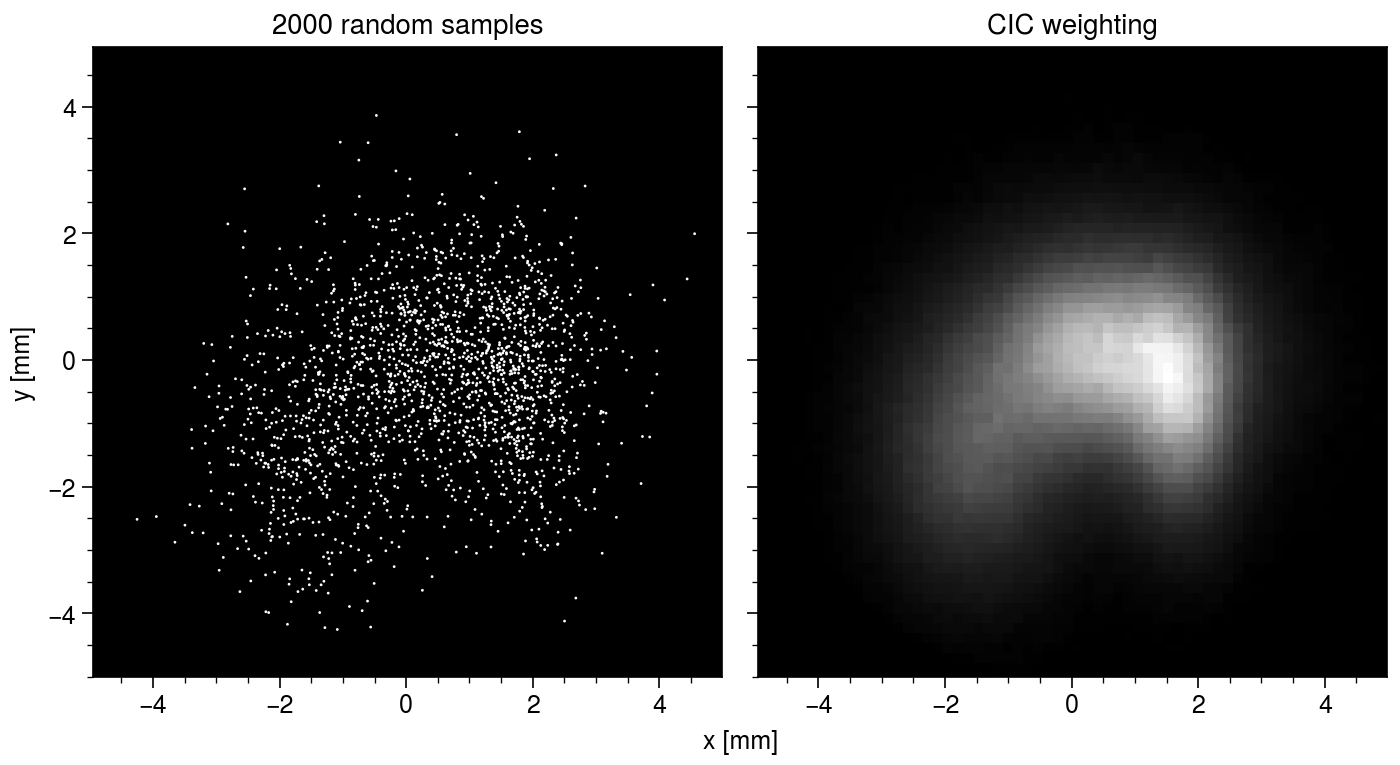

In [8]:
#| echo: True
#| code-fold: True
#| fig-cap: "Fig. 6. Test of cloud-in-cell (CIC) particle weighting on a regular 64 x 64 grid."
# Create a 2D bunch.
np.random.seed(1)
n_parts = 100000
_X = np.random.normal(scale=1.0, size=(n_parts, 2))
n_clusters = 4
for _ in range(n_clusters):
    loc = np.random.uniform(-2.0, 2.0, size=2)
    scale = np.random.uniform(0.5, 1.5, size=2)
    _X = np.vstack([_X, np.random.normal(loc=loc, scale=scale, size=(n_parts, 2))])
    
_X = _X - np.mean(_X)
idx, = np.where(np.sqrt(_X[:, 0]**2 + _X[:, 1]**2) < 5.0)
_X = _X[idx, :]
_X = _X - np.mean(_X)

X = np.zeros((_X.shape[0], 4))
X[:, (0, 2)] = _X

bunch = Bunch()
bunch.fill(X)
bunch.compute_extremum()

# Distribute the particles on an x-y grid.
n_bins = 64
grid = Grid(bunch.xlim, bunch.ylim, size=(n_bins, n_bins))
rho = grid.distribute(bunch.positions) 

# Plot
fig, axs = pplt.subplots(ncols=2, figwidth=7)
axs.format(xlabel='x [mm]', ylabel='y [mm]')

n_samp = 2000
idx = np.random.choice(X.shape[0], n_samp, replace=False)
X_samp = X[idx, :]
axs[0].scatter(X_samp[:, 0], X_samp[:, 2], s=1, c='w', ec='None')
axs[0].set_facecolor('k')
axs[1].pcolormesh(grid.x, grid.y, rho.T, cmap='mono_r')
axs.format(xlim=grid.xlim, ylim=grid.ylim)
axs[0].format(title=f'{n_samp} random samples')
axs[1].format(title='CIC weighting');

### Field solver 

The workhorse in the simulation loop is the field solver. We need to solve Poisson's equation:

$$
\left({\frac{\partial^2}{\partial x^2} + \frac{\partial^2}{\partial y^2}}\right) = -\frac{\rho\left(x, y\right)}{\varepsilon_0}.
$${#eq-label}

The discretized version of the equation reads

$$ 
\frac{\phi_{i+1,j} -2\phi_{i,j} +\phi_{i-1,j}}{{\Delta_x}^2} + \frac{\phi_{i,j+1} -2\phi_{i,j} + \phi_{i,j-1}}{{\Delta_y}^2} = -\frac{\rho_{i,j}}{\varepsilon_0}
$${#eq-label}

for a grid with spacing $\Delta_x$ and $\Delta_y$. There are multiple paths to a solution; we will focus on the method implemented in PyORBIT which utilizes the Fourier convolution theorem. Let's briefly go over this method. The potential from an infinite line of elementary charges at the origin with number density $\lambda$ is 

$$ 
\phi(\mathbf{x}) = -\frac{\lambda e}{2\pi\varepsilon_0} \ln{|\mathbf{x}|} = -\frac{\lambda e}{2\pi\varepsilon_0} \int{\ln{|\mathbf{x} - \mathbf{y}|}\delta(\mathbf{y})d\mathbf{y}}.
$${#eq-label}

Note that $\mathbf{y}$ is just a dummy variable. By letting $G(\mathbf{x} - \mathbf{y}) = -\ln{|\mathbf{x} - \mathbf{y}|}$ and $\rho(\mathbf{x}) = \delta(\mathbf{x})$, then up to a scaling factor we have

$$ 
\phi(\mathbf{x}) = \int{G(\mathbf{x} - \mathbf{y})\rho(\mathbf{y})d\mathbf{y}} = G(\mathbf{x}) * \rho(\mathbf{x}). 
$${#eq-label}

In this form the potential is a [convolution](https://en.wikipedia.org/wiki/Convolution) (represented by $*$) of the charge density $\rho$ with $G$, which is called the [Green's function](https://en.wikipedia.org/wiki/Green%27s_function). On the grid this will look like

$$
\phi_{i, j} = \sum_{k,l \ne i,j}{G_{i-k, j-l} \rho_{k, l}}.
$${#eq-Poisson_Green}

This solves the problem in $O(N^2)$ time complexity for $N$ grid points. This is already much faster than a direct force calculation but could still get expensive for fine grids. We can speed things up by exploiting the [convolution theorem](https://en.wikipedia.org/wiki/Convolution_theorem), which says that the Fourier transform of a convolution of two functions is equal to the product of their Fourier transforms. The Fourier transform is defined by

$$
\hat{\phi}(\mathbf{k})= \mathcal{F}\left[\phi(\mathbf{x})\right] = \int_{-\infty}^{\infty}{e^{-i\mathbf{k}\cdot\mathbf{x}} \phi(\mathbf{x}) d\mathbf{x}}.
$${#eq-label}

The convolution theorem then says
$$
\mathcal{F}\left[\rho * G\right] = \mathcal{F}\left[\rho\right] \cdot \mathcal{F}\left[G\right].
$${#eq-label}

For the discrete equation this gives

$$
\hat{\phi}_{n, m} = \hat{\rho}_{n, m} \hat{G}_{n, m},
$${#eq-label}

where the hat represents the discrete Fourier transform. The time complexity can be reduced to $O\left(N \log N\right)$ with the [FFT](https://en.wikipedia.org/wiki/Fast_Fourier_transform) algorithm at our disposal. 

There is a caveat to this method: @eq-Poisson_Green must be a circular convolution in order to use the FFT algorithm, which means $G$ must be periodic. But the beam is in free space (we've neglected any conducting boundary), so this is not true. We can make it true by doubling the grid size in each dimension. We then make $G$ a mirror reflection in the new quadrants so that it is periodic, and also set the charge density equal to zero in these regions. After running the method on this larger grid, the potential in the new quadrants will be unphysical; however, the potential in the original quadrant will be correct. There are also some tricks we can play to reduce the space complexity, and in the end doubling the grid size is not much of a price to pay for the gain in speed. The method is implemented in the `PoissonSolver` class.

In [9]:
class PoissonSolver:
    """Class to solve Poisson's equation on a 2D grid.
    
    Attributes
    ----------
    rho, phi, G : ndarray, shape (2*Nx, 2*Ny)
        The density (rho), potential (phi), and Green's function (G) at each
        grid point on a doubled grid. Only one quadrant (i < Nx, j < Ny)
        corresponds to to the real potential.
    """
    def __init__(self, grid, sign=-1.0):
        self.grid = grid
        new_shape = (2 * self.grid.Nx, 2 * self.grid.Ny)
        self.rho = np.zeros(new_shape)
        self.G = np.zeros(new_shape)
        self.phi = np.zeros(new_shape)
        
    def set_grid(self, grid):
        self.__init__(grid)
        
    def compute_greens_function(self):
        """Compute Green's function on doubled grid."""
        Nx, Ny = self.grid.Nx, self.grid.Ny
        Y, X = np.meshgrid(self.grid.x - self.grid.xmin, self.grid.y - self.grid.ymin)
        self.G[:Nx, :Ny] = -0.5 * np.log(X**2 + Y**2, out=np.zeros_like(X), 
                                         where=(X + Y > 0))
        self.G[Nx:, :] = np.flip(self.G[:Nx, :], axis=0)
        self.G[:, Ny:] = np.flip(self.G[:, :Ny], axis=1)
                
    def get_potential(self, rho):
        """Compute the scaled electric potential on the grid.
        
        Parameters
        ----------
        rho : ndarray, shape (Nx, Ny)
            Number of macroparticles at each grid point.
        
        Returns
        -------
        phi : ndarray, shape (Nx, Ny)
            Scaled electric potential at each grid point.
        """
        Nx, Ny = self.grid.Nx, self.grid.Ny
        self.rho[:Nx, :Ny] = rho
        self.compute_greens_function()
        self.phi = ifft2(fft2(self.G) * fft2(self.rho)).real
        return self.phi[:Nx, :Ny]

Running the algorithm gives the following potential on the doubled grid:

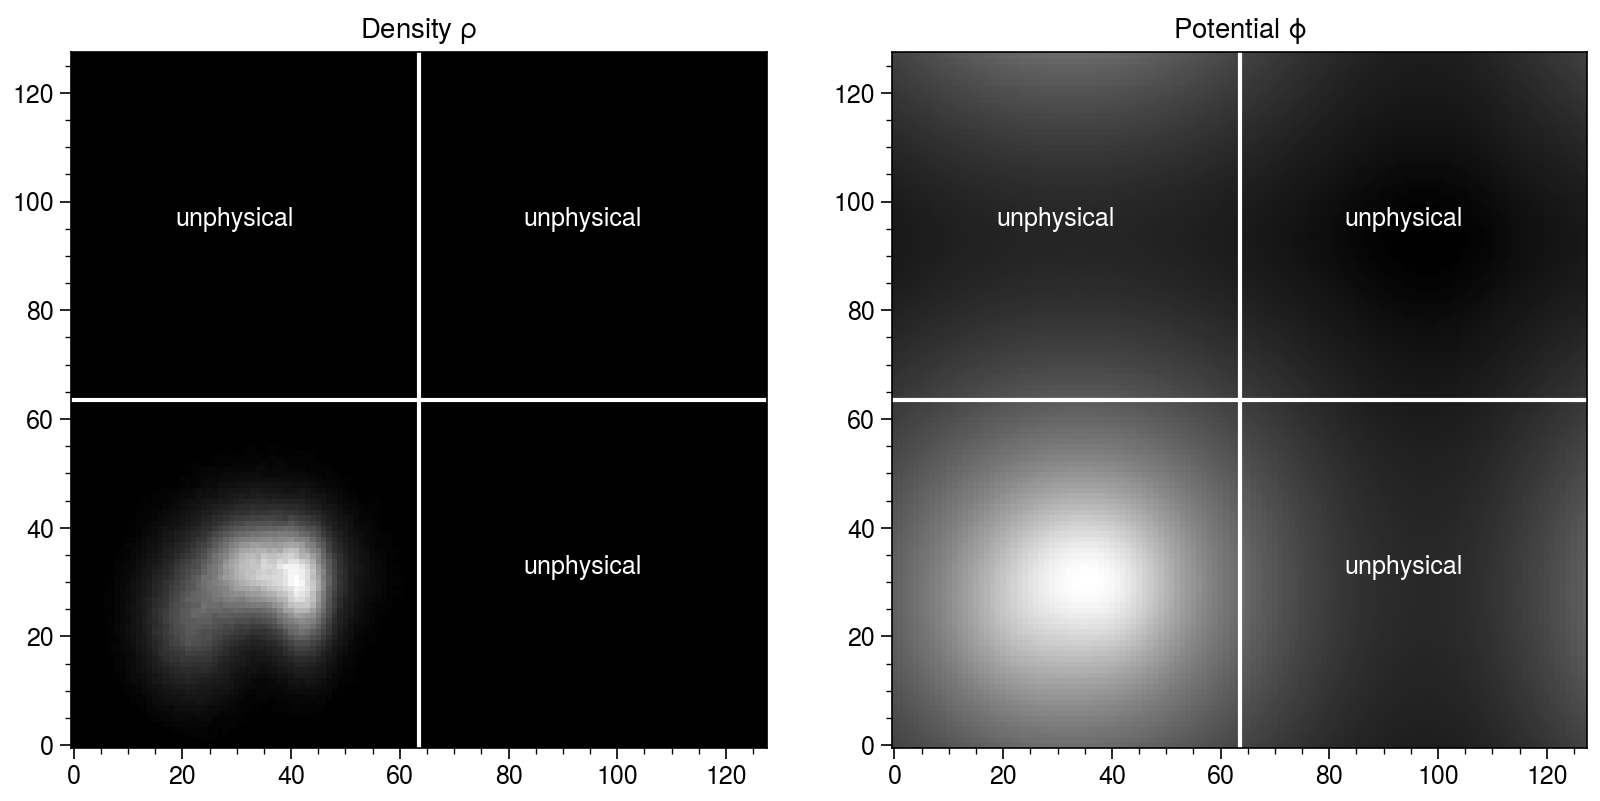

In [10]:
#| echo: true
#| code-fold: true
#| fig-cap: "Fig. 7. Electric potential on doubled grid."
solver = PoissonSolver(grid)
phi = solver.get_potential(rho)

fig, axs = pplt.subplots(ncols=2, figwidth=8.0, share=False, space=5)
axs[0].pcolormesh(solver.rho.T, cmap='mono_r')
axs[1].pcolormesh(solver.phi.T, cmap='mono_r')
for ax in axs:
    ax.axvline(grid.Nx - 0.5, c='w')
    ax.axhline(grid.Ny - 0.5, c='w')
    for xy in [(0.65, 0.75), (0.15, 0.75), (0.65, 0.25)]:
        ax.annotate('unphysical', xy=xy, xycoords='axes fraction', c='w')
axs[0].format(title=r'Density $\rho$')
axs[1].format(title=r'Potential $\phi$');

We can then approximate the gradient of the potential using second-order centered differencing. This gives

$$(\nabla\phi)_{i,j} = \frac{\phi_{i+1,j} - \phi_{i-1,j}}{2\Delta_x} \hat{x} + \frac{\phi_{i,j+1} - \phi_{i,j-1}}{2\Delta_y} \hat{y}. \tag{15}$$

The following plot shows the electric field at each position.

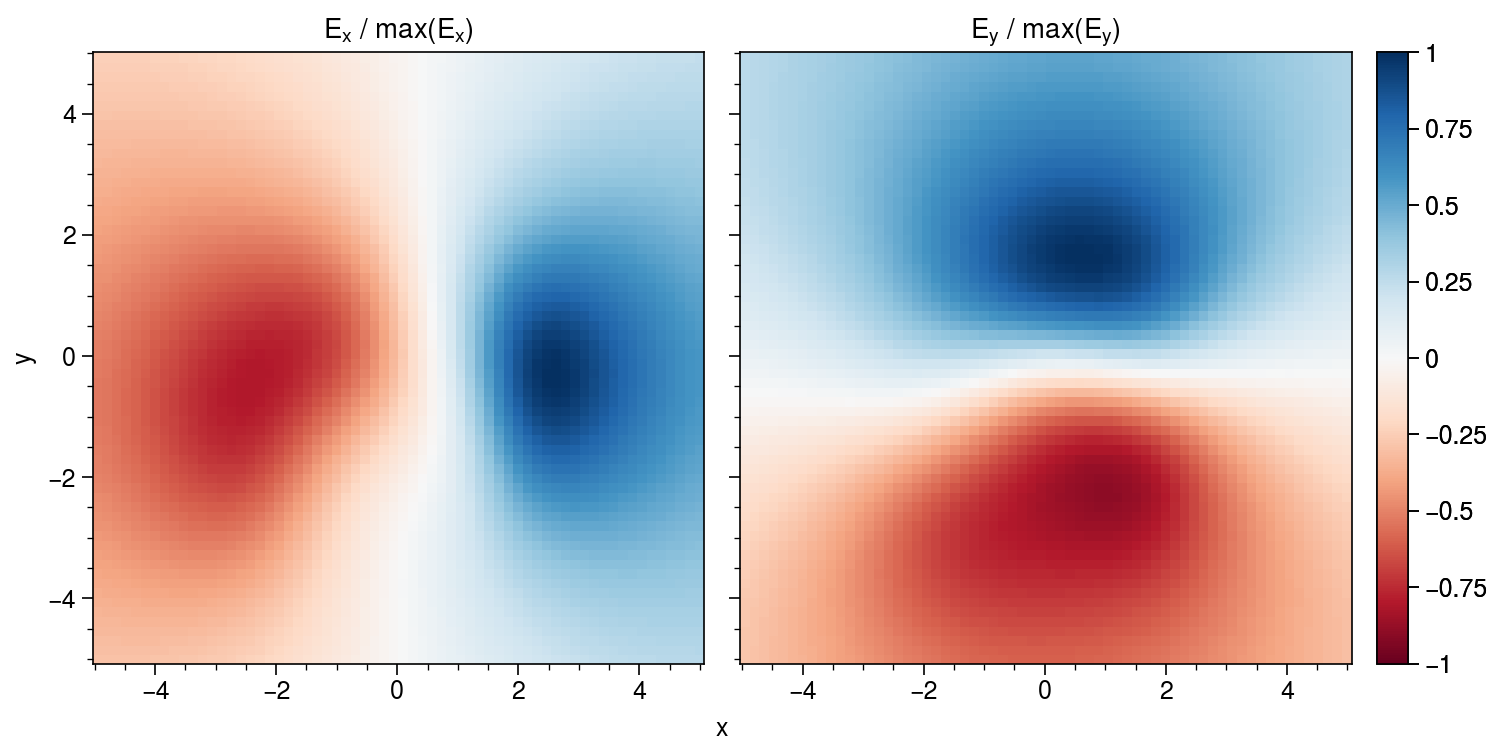

In [11]:
#| echo: true
#| code-fold: true
#| fig-cap: "Fig. 8. Electric field on original grid."
Ex, Ey = grid.gradient(-phi)

fig, axs = pplt.subplots(ncols=2, figwidth=7.5, sharey=True)
for ax, E in zip(axs, [Ex, Ey]):
    m = ax.pcolormesh(
        grid.x, grid.y, E.T / np.max(E), shading='auto', 
        vmin=-1.0, vmax=1.0, cmap='RdBu',
    )
fig.colorbar(m, width='1.25em')
axs.format(xlabel='x', ylabel='y')
axs[0].format(title=r'$E_x$ / max($E_x$)')
axs[1].format(title=r'$E_y$ / max($E_y$)')

Finally, the value of the electric field at each particle position can be interpolated from the grid.

In [12]:
Ex_int = grid.interpolate(Ex, bunch.positions)
Ey_int = grid.interpolate(Ey, bunch.positions)

### Particle mover 

All we need to do in this step is integrate the equations of motion. A common method is [leapfrog integration](https://en.wikipedia.org/wiki/Leapfrog_integration) in which the position and velocity are integrated out of phase as follows:

$$ 
m \left(\frac{\mathbf{v}_{i+1/2} - \mathbf{v}_{i-1/2}}{\Delta_t}\right) = \mathbf{F}(\mathbf{x}_i),
$${#eq-label}

$$ 
\frac{\mathbf{x}_{i+1} - \mathbf{x}_i}{\Delta_t} = \mathbf{v}_{i+1/2}
$${#eq-label}

![Fig. 9. Leapfrog integration. (Source: S. Lund.)](leapfrog.png){width=75%}

A different scheme must be used when velocity-dependent forces are present. This is a symplectic integrator, which means it conserves energy. It is also second-order accurate, meaning that its error is proportional to the square of the $\Delta_t$. Finally, it is time-reversible. The only complication is that, because the velocity and position are out of phase, we need to push the velocity back one half-step before starting the simulation, and push it one half-step forward when taking a measurement. 

## Putting it all together
### Simulation loop

We have all the tools to implement the simulation loop. While $s < s_{max}$ we: 

1. Compute the charge density on the grid.
2. Find the electric potential on the grid.
3. Interpolate the electric field at the particle positions.
3. Update the particle positions.

We'll first create a `History` class which stores the beam moments or phase space coordinates.

In [ ]:
class History:
    """Class to store bunch data over time.
    
    Atributes
    ---------
    moments : list
        Second-order bunch moments. Each element is ndarray of shape (10,).
    coords : list
        Bunch coordinate arrays. Each element is ndarray of shape (nparts, 4)
    moment_positions, coord_positions : list
        Positions corresponding to each element of `moments` or `coords`.
    """
    def __init__(self, bunch, samples='all'):
        self.X = bunch.X
        self.moments, self.coords = [], []
        self.moment_positions, self.coord_positions = [], []
        if samples == 'all' or samples >= bunch.nparts:
            self.idx = np.arange(bunch.nparts)
        else:
            self.idx = np.random.choice(bunch.nparts, samples, replace=False)
        
    def store_moments(self, s):
        Sigma = np.cov(self.X.T)
        self.moments.append(Sigma[np.triu_indices(4)])
        self.moment_positions.append(s)
        
    def store_coords(self, s):
        self.coords.append(np.copy(self.X[self.idx, :]))
        self.coord_positions.append(s)
        
    def package(self):
        self.moments = np.array(self.moments)
        self.coords = np.array(self.coords)

Now we'll create a `Simulation` class.

In [ ]:
class Simulation:
    """Class to simulate the evolution of a charged particle bunch in free space.
        
    Attributes
    ----------
    bunch : Bunch:
        The bunch to track.
    distance : float
        Total tracking distance [m].
    step_size : float
        Distance between force calculations [m].
    nsteps : float
        Total number of steps = int(length / ds).
    steps_performed : int
        Number of steps performed so far.
    s : float
        Current bunch position.
    history : History object
        Object storing historic bunch data.
    meas_every : dict
        Dictionary with keys: 'moments' and 'coords'. Values correspond to the 
        number of simulations steps between storing these quantities. For
        example, `meas_every = {'coords':4, 'moments':2}` will store the
        moments every 4 steps and the moments every other step. Defaults to
        storing only the initial and final positions.
    samples : int
        Number of bunch particles to store when measuring phase space
        coordinates. Defaults to the entire coordinate array.
    """
    def __init__(self, bunch, distance, step_size, grid_size, meas_every={}, 
                 samples='all'):
        self.bunch = bunch
        self.distance, self.step_size = distance, step_size 
        self.nsteps = int(distance / step_size)
        self.grid = Grid(size=grid_size)
        self.solver = PoissonSolver(self.grid)
        self.fields = np.zeros((bunch.nparts, 2))
        self.history = History(bunch, samples)  
        self.s, self.steps_performed = 0.0, 0
        self.meas_every = meas_every
        self.meas_every.setdefault('moments', self.nsteps)
        self.meas_every.setdefault('coords', self.nsteps)
        self.sc_factor = bunch.perveance / bunch.nparts

    def set_grid(self):
        """Set grid limits from bunch size."""
        self.bunch.compute_extremum()
        self.grid.set_lims(self.bunch.xlim, self.bunch.ylim)
        self.solver.set_grid(self.grid)
        
    def compute_electric_field(self):
        """Compute self-generated electric field."""
        self.set_grid()
        rho = self.grid.distribute(self.bunch.positions)
        phi = self.solver.get_potential(rho)
        Ex, Ey = self.grid.gradient(-phi)
        self.fields[:, 0] = self.grid.interpolate(Ex, self.bunch.positions)
        self.fields[:, 1] = self.grid.interpolate(Ey, self.bunch.positions)
                            
    def kick(self, step_size):
        """Update particle slopes."""
        self.bunch.X[:, 1] += self.sc_factor * self.fields[:, 0] * step_size
        self.bunch.X[:, 3] += self.sc_factor * self.fields[:, 1] * step_size
        
    def push(self, step_size):
        """Update particle positions."""
        self.bunch.X[:, 0] += self.bunch.X[:, 1] * step_size
        self.bunch.X[:, 2] += self.bunch.X[:, 3] * step_size
        
    def store(self):
        """Store bunch data."""
        store_moments = self.steps_performed % self.meas_every['moments'] == 0
        store_coords = self.steps_performed % self.meas_every['coords'] == 0
        if not (store_moments or store_coords):
            return
        Xp = np.copy(self.bunch.X[:, [1, 3]])
        self.kick(+0.5 * self.step_size) # sync positions/slopes
        if store_moments:
            self.history.store_moments(self.s)
        if store_coords:
            self.history.store_coords(self.s)
        self.bunch.X[:, [1, 3]] = Xp
        
    def run(self, meas_every={}):
        """Run the simulation."""
        self.store()
        self.compute_electric_field()
        self.kick(-0.5 * self.step_size) # desync positions/slopes
        for i in trange(self.nsteps):
            self.compute_electric_field()
            self.kick(self.step_size)
            self.push(self.step_size)
            self.s += self.step_size
            self.steps_performed += 1
            self.store()
        self.history.package()

### Benchmark: freely expanding Vlasov equilibrium distribution

We need some way of checking our method's accuracy. Luckily there is an analytic benchmark available: the Kapchinskij-Vladimirskij (KV) distribution. Without going into any detail, the beam projects to a uniform density ellipse in the $x$-$y$ plane, and the space charge forces produced within this ellipse are *linear* (in general space charge forces are nonlinear). If we plug the KV distribution into the Vlasov equation, it can be seen that these forces will remain linear for all time if the external focusing forces are also linear. As a consequence, a set of self-consistent differential equations describing the evolution of the ellipse boundary can be written down. If we consider the beam to be an upright ellipse with semi-axis $a$ along the $x$ axis and $b$ along the $y$ axis, then without external fields the equations read:

$$ a'' = \frac{2Q}{a + b} + \frac{\varepsilon_x}{a^3}, $$
$$ b'' = \frac{2Q}{a + b} + \frac{\varepsilon_y}{b^3}. \tag{18}$$

These are known as the *KV envelope equations* or simply *envelope equations*. $Q$, called the *perveance*, is a dimensionless number which is proportional to the beam intensity but reduced by the beam energy. We can think of this constant as a measure of the space charge strength. The $\varepsilon_x$ and $\varepsilon_y$ terms are called the *emittances* and determine the area occupied by the beam in $x$-$x'$ and $y$-$y'$ phase space. For example, a beam with all particles sitting perfectly still in the $x$-$y$ plane has no emittance, but a beam which is instead spreading out has a nonzero emittance. These emittances will also be conserved for the KV distribution. The following function integrates the envelope equations.

In [ ]:
def track_env(X, positions, perveance=0.0):
    """Track beam moments (assuming KV distribution) through free space.
    
    Parameters
    ----------
    X : ndarray, shape (nparts, 4)
        Transverse bunch coordinate array.
    positions : list
        List of positions at which to evaluate the equations.
    perveance : float
        The dimensionless space charge perveance.
        
    Returns
    -------
    ndarray, shape (len(positions), 4)
        Each row gives [a, a', b, b'], where a and b are the beam
        radii in the x and y dimension, respectively.
    """
    Sigma = np.cov(X.T)
    a, b = np.sqrt(Sigma[0, 0]), np.sqrt(Sigma[2, 2])
    ap, bp = Sigma[0, 1] / a, Sigma[2, 3] / b
    epsx = np.sqrt(np.linalg.det(Sigma[:2, :2]))
    epsy = np.sqrt(np.linalg.det(Sigma[2:, 2:]))

    def derivs(env, s):
        a, ap, b, bp = env
        envp = np.zeros(4)
        envp[0], envp[2] = ap, bp
        envp[1] = 0.5 * perveance/(a + b) + epsx**2 / a**3
        envp[3] = 0.5 * perveance/(a + b) + epsy**2 / b**3
        return envp
    
    return odeint(derivs, [a, ap, b, bp], positions, atol=1e-14)

Some care must be taken in the choice of simulation parameters; we need a fine enough grid to resolve the hard edge of the beam and enough macroparticles per grid cell to collect good statistics. I chose what I thought was reasonable: 128,000 macroparticles, a step size of 2.5 cm, and a $128 \times 128$ grid. Let's create and track four identical KV distributions, each with a different intensity.

In [ ]:
# Bunch parameters
nparts = 128000
bunch_length = 250.0 # [m]
intensities = [0.0, 10.0e14, 20.0e14, 40.0e14]

# Simulation parameters
distance = 10.0 # [m]
step_size = 0.025 # [m]
grid_size = (128, 128)
samples = 10000
meas_every = {
    'moments': int(0.1 * distance / step_size), 
    'coords': 4
}

# Create KV bunch in normalized coordinates (surface of 4D unit sphere)
X = np.random.normal(size=(nparts, 4))
X = np.apply_along_axis(lambda row: row / np.linalg.norm(row), 1, X)

# Scale by emittance
eps_x, eps_y = 10e-6, 10e-6
A = 2 * np.sqrt(np.diag([eps_x, eps_x, eps_y, eps_y]))
X = np.apply_along_axis(lambda row: np.matmul(A, row), 1, X)

# Scale beam size and divergence relative to emittance
alpha_x = alpha_y = 0.0
beta_x = beta_y = 20.0
V = np.zeros((4, 4))
V[:2, :2] = np.sqrt(1.0 / beta_x)* np.array([[beta_x, 0.0], [alpha_x, 1.0]])
V[2:, 2:] = np.sqrt(1.0 / beta_y)* np.array([[beta_y, 0.0], [alpha_y, 1.0]])
X = np.apply_along_axis(lambda row: np.matmul(V, row), 1, X)

# Create and track bunches
sims = []
for intensity in intensities:
    bunch = Bunch(intensity, bunch_length)
    bunch.fill(np.copy(X))
    sim = Simulation(bunch, distance, step_size, grid_size, meas_every=meas_every, samples=samples)
    sim.run()
    sims.append(sim)

In [ ]:
#| echo: true
#| code-fold: true
#| fig-cap: "Fig. 10. Benchmark: free expansion of a KV distribution. Solid lines show the exact results obtained by integrating the KV envelop equations. Dots show the PIC results."
bunch_positions = sims[0].history.moment_positions
env_positions = np.linspace(0, distance, 400)
rms_sizes_lists = {'bunch':[], 'env':[]}
for sim in sims:
    rms_sizes_lists['bunch'].append(np.sqrt(sim.history.moments[:, [0, 7]]))
    rms_sizes_lists['env'].append(track_env(X, env_positions, sim.bunch.perveance)[:, [0, 2]])

fig, axs = pplt.subplots(ncols=2, figsize=(7.25, 2.75), spany=False)
alphas = np.linspace(0.4, 1.0, 4)
cycle = pplt.Cycle(pplt.Colormap('blues', left=0.3))
colors = cycle.by_key()['color'][::3]
for key, rms_sizes_list in rms_sizes_lists.items():
    for rms_sizes, alpha, color in zip(rms_sizes_list, alphas, colors):
        for i, ax in enumerate(axs):
            if key == 'env':
                ax.plot(env_positions, 1000.0 * rms_sizes[:, i], c=color, alpha=alpha)
            elif key == 'bunch':
                ax.scatter(bunch_positions, 1000.0 * rms_sizes[:, i], s=8, c=color, zorder=99)
            
lines = [Line2D([0], [0], color=color) for color in colors]
axs[0].legend(lines, [f'$I/I_0$ = {i}' for i in (0, 1, 2, 4)], ncols=1, fontsize=7)
axs[0].set_title('Horizontal')
axs[1].set_title('Vertical')
axs.format(xlim=(-0.5, 10.5), ylabel='RMS beam size [$mm$]', xlabel='Position [m]')

This plot shows the horizontal and vertical beam size over time for each of the four chosen beam intensities. The solid lines are the result of integrating the envelope equations, while the dots are the result of the PIC calculation. Notice that the beam expands on its own due to the nonzero emittance and that the effect of space charge is to increase the expansion rate. It seems to be quite accurate over this distance, and the runtime is acceptable for my purposes. Here is the evolution of 10,000 randomly sampled macroparicles compared with the KV envelope.

In [ ]:
#| echo: true
#| code-fold: true
# Get coordinates
coords_list = [sim.history.coords for sim in sims]
positions = sims[0].history.coord_positions
umax = 1.25 * max([np.max(np.max(coords, axis=1)[:, [0, 2]]) for coords in coords_list])
umax = umax * 1000.0

# Create figure
fig, axs = pplt.subplots(nrows=2, ncols=2, figwidth=5.0)
axs.format(
    xspineloc='bottom', yspineloc='left',
    xlim=(-umax, umax), ylim=(-umax, umax),
    xlabel='x [mm]', ylabel='y [mm]'
)
axs[1].legend([Line2D([0], [0], color='red6')], ['KV envelope'], frameon=False, loc=(0.5, 0.95))
for i, ax in enumerate(axs):
    ax.annotate(f'$I/I_0$ = {i}', xy=(0.05, 0.9), xycoords='axes fraction')
plt.close()

# Create lines
lines = []
for ax in axs:
    line, = ax.plot([], [], ms=1.25, c='black', marker='.', lw=0, mew=0, fillstyle='full')
    lines.append(line)
        
def update(t):
    for ax, coords, line, rms_sizes_list in zip(axs, coords_list, lines, rms_sizes_lists['env']):
        line.set_data(1000.0 * coords[t, :, 0], 1000.0 * coords[t, :, 2])
        rms_sizes_list = rms_sizes_list[::4]
        a, b = 1000.0 * rms_sizes_list[t]
        ax.patches = []
        ax.add_patch(Ellipse((0.0, 0.0), 4.0 * a, 4.0 * b, color='red6', fill=False, zorder=100, lw=1))
    axs[0].set_title('s = {:.2f} m'.format(positions[t]))
        
frames = len(coords_list[0]) - 1
anim = animation.FuncAnimation(fig, update, frames=frames, interval=1000.0 / 20.0)

In [ ]:
#| echo: false
#| output: false
anim.save('./_output_anim.gif', dpi=250)

![Fig. 11. Evolution of 10,000 macroparticles (black) and KV envelope (red) during free-expansion.](./_output_anim.gif){width=70%}

## Conclusion 

This post implemented an electrostatic PIC solver in Python. I learned quite a bit from doing this and was happy to see my calculations agree with the theoretical benchmark. One extension of this code would be to consider the velocity-dependent force from magnetic fields. It would also be straightforward to extend the code to 3D. Finally, all the methods used here are applicable to gravitational simulations. Here are some helpful references:

* [USPAS course](https://people.nscl.msu.edu/~lund/uspas/sbp_2018/)
* [Hockney & Eastwood](https://www.amazon.com/Computer-Simulation-Using-Particles-Hockney/dp/0852743920)
* [Birdsall & Langdon](https://www.amazon.com/Plasma-Physics-via-Computer-Simulation/dp/0750310251)